In [1]:
import matplotlib.pyplot as plt
from cycler import cycler
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from polan import fp2poly,plot_poly

#define a reference profile based on a representative polysome experimental profile
ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
ref_peaks = ref_peaks/ np.sum(ref_peaks)
x_ref,y_ref = plot_poly(ref_peaks)

<h1>In this Notebook</h1>
<ul style="font-size:24px">
    <li><a href="#comp">Assessing similarity between datasets in RNA-Seq, Ribo-Seq and computed TE data</a></li>
    <li><a href="#CHX">Comparison of cycloheximide concentrations</a></li>
    <li><a href="#libraries">Comparison of library preparation methods</a></li>
</ul>

<a name="comp"></a>
<h2>Do RNA-Seq and Ribo-Seq data show similar differences between datasets?</h2> 
<p>For each dataset, RNAs per cell, Ribosomes per gene per cell, and Ribosomes per RNA are computed from the RNA and Ribo counts. Dataset differences between RNA numbers, Ribosome numbers, and translational efficiency are then projected into two dimensions using the t-sne function from SKLearn (50 repeated projections). The spread of the projections is compared to assess whether differences arise predominantly from one type of data or are spreead across the different types of data.</p>

In [2]:
#prepare separate tables containing RNA_Prints, Ribo_Prints and Ribo_Densities for each GEO Dataset
genes = pd.read_csv('Data/sacCer3 genes.csv')[['name','length']]
genes.columns = ['ORF','length']
datasets = pd.read_csv('Data/Datasets.csv')
RNA_dats,Ribo_dats,RperR_dats = genes[['ORF',]],genes[['ORF',]],genes[['ORF',]]
dataset_list,cluster_list = [],[],
for dataset in datasets['SeriesID']:
    #read in dataset
    this_set = pd.read_csv('Data/' + dataset + '.csv')
    #ignore datasets without RNA data
    if 'RNA_Prints' not in this_set.columns:
        continue
    #combine dataset with gene legnth information, then compute RNAs per cell, Ribosomes per gene and Ribosomes per RNA
    this_set = genes.merge(this_set,how='inner',on='ORF')
    this_set['RNA_RPKM'] = this_set['RNA_Prints'] / (this_set['length'] / 1000)
    this_set['RNAs'] = this_set['RNA_RPKM']/this_set['RNA_RPKM'].sum()*60000
    this_set['Ribos'] = this_set['Ribo_Prints']/this_set['Ribo_Prints'].sum()*170000
    this_set['RperR'] = (this_set['Ribos'] / this_set['RNAs'])
    #merge info for this dataset with all other dataset
    RNA_dats = RNA_dats.merge(this_set[['ORF','RNAs']],how='inner',on='ORF')
    Ribo_dats = Ribo_dats.merge(this_set[['ORF','Ribos']],how='inner',on='ORF')
    RperR_dats = RperR_dats.merge(this_set[['ORF','RperR']],how='inner',on='ORF')
    #dataset_list.append(dataset)
#remove rows with inf or nan
Ribo_dats = Ribo_dats.replace((-np.inf,np.inf),np.nan).dropna()
RNA_dats = RNA_dats.replace((-np.inf,np.inf),np.nan).dropna()
RperR_dats = RperR_dats.replace((-np.inf,np.inf),np.nan).dropna()
#transpose data for use with tsne
Ribo_dats = np.transpose(np.array(Ribo_dats.iloc[:,1:]))
RNA_dats = np.transpose(np.array(RNA_dats.iloc[:,1:]))
RperR_dats = np.transpose(np.array(RperR_dats.iloc[:,1:]))

In [3]:
#do t-sne
repeats = 50
RNAs,Ribos,RperRs = np.array([[0,0]]),np.array([[0,0]]),np.array([[0,0]])

for n in range(repeats):
    Ribo_tsne = TSNE().fit_transform(Ribo_dats)
    Ribos = np.append(Ribos,Ribo_tsne,axis=0)
    RNA_tsne = TSNE().fit_transform(RNA_dats)
    RNAs = np.append(RNAs,RNA_tsne,axis=0)
    RperR_tsne = TSNE().fit_transform(RperR_dats)
    RperRs = np.append(RperRs,RperR_tsne,axis=0)


Ribos = Ribos[1:,:]
RNAs=RNAs[1:,:]
RperRs=RperRs[1:,:]

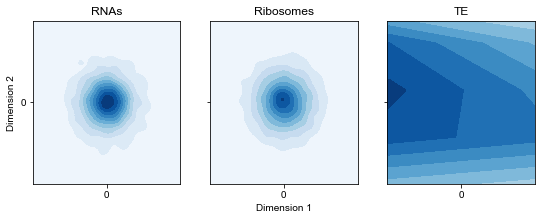

In [4]:
fig,ax = plt.subplots(1,3,sharey=True,sharex=True,figsize=(9,3))
sns.set_style("white")
sns.kdeplot(RNAs[:,0],RNAs[:,1], ax=ax[0],cmap='Blues',shade=True), ax[0].set_title('RNAs')
ax[0].set_ylabel('Dimension 2')
sns.kdeplot(Ribos[:,0],Ribos[:,1], ax=ax[1],cmap='Blues',shade=True), ax[1].set_title('Ribosomes')
ax[1].set_xlabel('Dimension 1')
sns.kdeplot(RperRs[:,0],RperRs[:,1], ax=ax[2],cmap='Blues',shade=True), ax[2].set_title('TE')
ax[0].set_xlim((-250,+250)), ax[0].set_ylim((-250,+250)), ax[0].set_yticks([0]), ax[0].set_xticks([0])
plt.savefig('Dataset_Similarities.svg')
plt.show()

<a name="CHX"></a>
<h2>Cycloheximide Series</h2>
<p>This analyses data generated by <a href="https://www.ncbi.nlm.nih.gov/pubmed/25056308" target=_blank>Gerashchenko and Gladyshev (2014)</a> using a cycloheximide concentration series. The dataset is <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE59573" target=_Blank>GSE59573</a>. "1x CHX" refers to the standard final concentration of 100 &mu;g/ml.</p>

In [5]:
#read in the CHX concentration series data and produce the peak information
poly_vols = []
all_dats = pd.read_csv('Data/GSE59573_all_CHX_concs.csv')
for col in range(1,all_dats.shape[1]):
    dats = all_dats.iloc[:,[0,col]]
    dats.columns = ['ORF','Ribo_Prints']
    poly_vols.append(fp2poly(dats,from_file=False))

Using reference mRNA data.
Using reference mRNA data.
Using reference mRNA data.
Using reference mRNA data.
Using reference mRNA data.
Using reference mRNA data.
Using reference mRNA data.


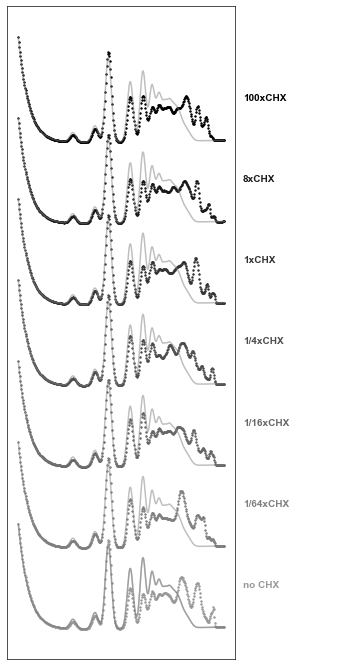

In [6]:
#plot the results
labels = list(all_dats.columns[1:])
labels = [l.replace('_','/') for l in labels]
labels = [l.replace('0/','no ') for l in labels]
colors=plt.cm.gist_yarg(np.linspace(0.4,1,len(poly_vols)))
fig,ax = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]},figsize = (6,12))
ax[0].set_prop_cycle(cycler(color=colors))
ax[0].plot(x_ref,y_ref,c='grey', label='experimental',alpha = 0.5)
offset_by = 5
offset = 0
for trace_no in range(len(poly_vols)):    
    ax[0].plot(x_ref,y_ref+offset ,c='grey', label='experimental',alpha = 0.5)    
    x,y = plot_poly(poly_vols[trace_no])
    ax[0].scatter(x,y+offset,s=2,label = labels[trace_no])
    ax[1].text(-0.3,offset+max(y_ref[20:])/2,labels[trace_no],color = colors[trace_no],
              fontdict={'weight':'bold'})
    offset += offset_by
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].axis('off')
#plt.savefig('CHX_series.svg')
plt.show()

<a name="libraries"></a>
<h2>Library preparation protocols</h2>
<p>This analyses data from <a href="https://www.ncbi.nlm.nih.gov/pubmed/27450428" target=_blank>Lecanda <i>et al.</i> (2016).</a> which tests a variety of library preparation protocols. The dataset used is <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE84746" target=_blank>GSE84746</a>.</p>

In [7]:
#analysis of library prep series
poly_vols = []
for file in ['GSE84746_DualLigation.csv','GSE84746_3N.csv',
             'GSE84746_4N.csv','GSE84746_4N_low.csv',
             'GSE84746_nonrand.csv','GSE84746_nonrand_low.csv']:
    poly_vols.append(fp2poly(file))
    

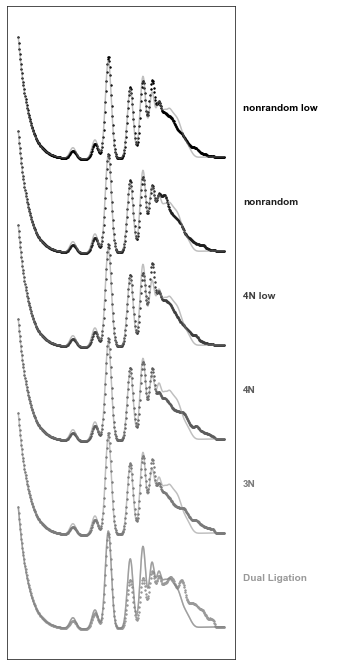

In [8]:
#plot the results
labels = ['Dual Ligation','3N','4N','4N low','nonrandom','nonrandom low']
colors=plt.cm.gist_yarg(np.linspace(0.4,1,len(poly_vols)))
fig,ax = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]},figsize = (6,12))
ax[0].set_prop_cycle(cycler(color=colors))
ax[0].plot(x_ref,y_ref,c='grey', label='experimental',alpha = 0.5)
offset_by = 5
offset = 0
for trace_no in range(len(poly_vols)):    
    ax[0].plot(x_ref,y_ref+offset ,c='grey', label='experimental',alpha = 0.5)    
    x,y = plot_poly(poly_vols[trace_no])
    ax[0].scatter(x,y+offset,s=2,label = labels[trace_no])
    ax[1].text(-0.3,offset+max(y_ref[20:])/2,labels[trace_no],color = colors[trace_no],
              fontdict={'weight':'bold'})
    offset += offset_by
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].axis('off')
#plt.savefig('library_series.svg')
plt.show()